# Import the Libraries

In [ ]:
!chmod +x download_data.sh
!./download_data.sh

--2024-05-05 17:47:04--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip?download=true
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.55, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1715190425&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTE5MDQyNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1N

In [ ]:
!mkdir lol_dataset_prosessed
!mkdir lol_dataset_prosessed/high
!mkdir lol_dataset_prosessed/highi
!mkdir lol_dataset_prosessed/highr
!mkdir lol_dataset_prosessed/low
!mkdir lol_dataset_prosessed/lowi
!mkdir lol_dataset_prosessed/lowr

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers
import matplotlib.pyplot as plt
from einops import rearrange
from PIL import Image
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torch.nn.init as init
from datasetLoaderLol import check_images
from datasetLoaderLol import LOL_Dataset
from datasetLoaderLol import LOL_Dataset_Diffusion
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ModelTDN import TDN as TDN
import math
from diffusionModel import Denoiser
from diffusionModel import Diffusion
import zipfile
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt


# Hyperparameters

In [ ]:
SHUFFLE = False
BATCH_SIZE = 3
EPOCHS = 15
GamaRC = 0.1
GamaSM = 0.1
GamaCT = 1
AlphaRec = 0.3
lr = 0.0001


# Select Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets


In [ ]:
DATASET_TRAIN_HIGH_PATH = './lol_dataset/our485/high'
DATASET_TRAIN_LOW_PATH = './lol_dataset/our485/low'
dataset_train_high = LOL_Dataset(DATASET_TRAIN_HIGH_PATH)
dataset_train_low = LOL_Dataset(DATASET_TRAIN_LOW_PATH)
data_loader_train_high = DataLoader(dataset_train_high, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
data_loader_train_low = DataLoader(dataset_train_low, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Loss for TDN

In [ ]:
def total_loss(image_batch_low, image_batch_high,predict_low, predict_high, predict_low_ill, predict_high_ill,c):
    return GamaRC*ReflectanceConsistencyLoss(predict_low, predict_high) + RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill)
    + GamaSM*IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low_ill, predict_high_ill,c)

def ReflectanceConsistencyLoss(predict_low, predict_high):
    return torch.norm(predict_high - predict_low, p=1)

def RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill):
    return torch.norm(predict_high.to(device)*predict_high_ill - image_batch_high.to(device), p=1) + AlphaRec * torch.norm(predict_low.to(device)*predict_low_ill - image_batch_low.to(device),p=1)

def IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low, predict_high,c):
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)


    grayscale_images_low = torch.mean(image_batch_low, dim=1, keepdim=True) #[0]
    grayscale_images_low = torch.sigmoid(grayscale_images_low);
    grad_x_low = F.conv2d(grayscale_images_low, sobel_x, padding=1)
    grad_y_low = F.conv2d(grayscale_images_low, sobel_y, padding=1)
    grad_magnitude_low = torch.sqrt(grad_x_low**2 + grad_y_low**2)
    W_l = torch.exp(-c*grad_magnitude_low).to(device)


    grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grayscale_images_high = torch.sigmoid(grayscale_images_high);

    grad_x_high = F.conv2d(grayscale_images_high, sobel_x, padding=1)
    grad_y_high = F.conv2d(grayscale_images_high, sobel_y, padding=1)
    grad_magnitude_high = torch.sqrt(grad_x_high**2 + grad_y_high**2)
    W_h = torch.exp(-c*grad_magnitude_high).to(device)

    sobel_x = sobel_x.cuda()
    sobel_y = sobel_y.cuda()
    #grayscale_predict_low = torch.mean(predict_low, dim=1, keepdim=True) #[0]
    grad_x_low_predict = F.conv2d((predict_low), sobel_x, padding=1)
    grad_y_low_predict = F.conv2d((predict_low), sobel_y, padding=1)
    L_l = torch.sqrt(grad_x_low_predict**2 + grad_y_low_predict**2+ 1e-8)


    #grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grad_x_high_predict = F.conv2d((predict_high), sobel_x, padding=1)
    grad_y_high_predict = F.conv2d((predict_high), sobel_y, padding=1)
    L_h = torch.sqrt(grad_x_high_predict**2 + grad_y_high_predict**2 + 1e-8)


    return torch.norm( (W_l * L_l)) + torch.norm((W_h * L_h))




# Training TDN

In [ ]:
model = TDN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, ((data_low), (data_high)) in enumerate(zip(data_loader_train_low, data_loader_train_high)):
        optimizer.zero_grad()
        outputs_lowR,outputs_low = model(data_low.to(device))
        outputs_highR, outputs_high = model(data_high.to(device))
        loss = total_loss( data_low, data_high,outputs_lowR,outputs_highR,outputs_low,outputs_high,10)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        single_image = outputs_high[0]
        if i % 15 == 14:  # Her 100 mini-batch'de bir kaybı yazdır
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0

print('Training finished')

# Save Model


In [10]:
model_path = 'TDN.pth'
torch.save(model.state_dict(),model_path)

# Inference TDN

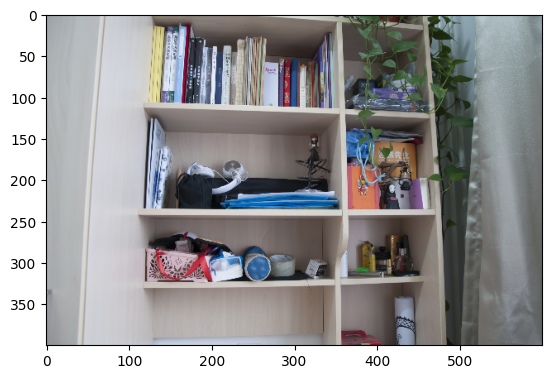

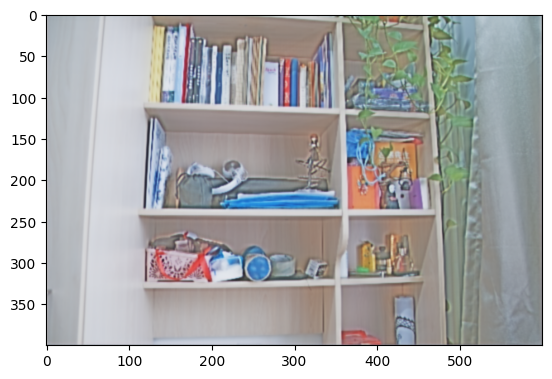

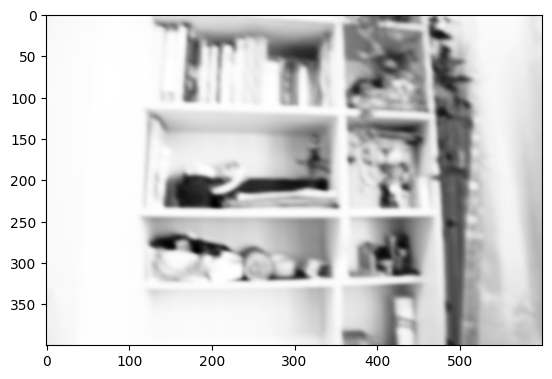

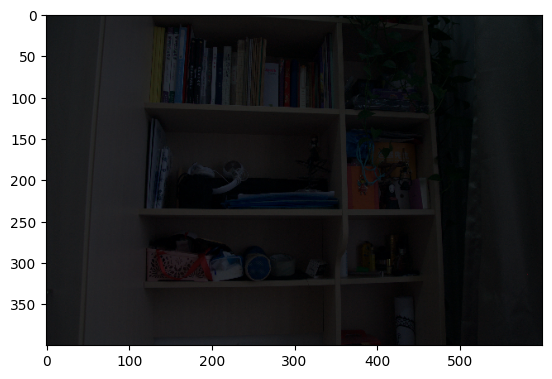

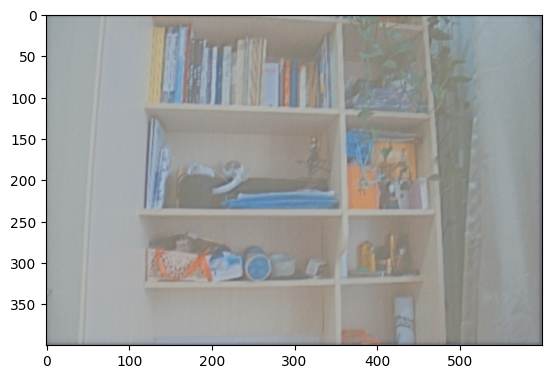

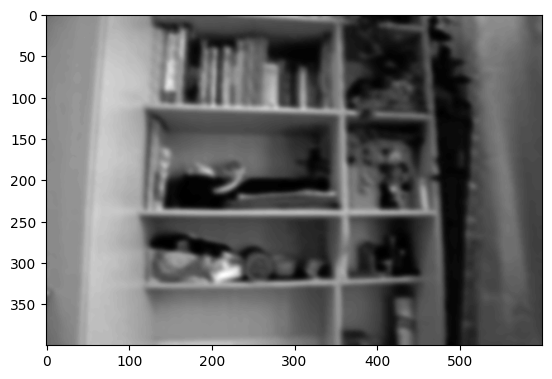

In [13]:
model = TDN().to(device)
model.load_state_dict(torch.load("TDN.pth"))

##### Prepare dataloader for inference, make batch size 1 ###########################
data_loader_train_high = DataLoader(dataset_train_high, batch_size=1, shuffle=SHUFFLE)
data_loader_train_low  = DataLoader(dataset_train_low, batch_size=1, shuffle=SHUFFLE)
#####################################################################################
with torch.no_grad():
  number_image=0
  for i in data_loader_train_high:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()

      save_path = './lol_dataset_prosessed/high/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/highr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image,cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/highi/'+str(number_image)+'.png'
      image.save(save_path)
with torch.no_grad():
  number_image=0
  for i in data_loader_train_low:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/low/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/lowr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image, cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/lowi/'+str(number_image)+'.png'
      image.save(save_path)


# Hyperparameters for Diffusion

In [ ]:
torch.cuda.empty_cache()
img_size = (100, 100, 3)
timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
hidden_dims = [hidden_dim for _ in range(n_layers)]
n_timesteps = 1000
beta_minmax = [1e-4, 2e-2]
lr = 5e-5
batch_size = 64
num_epochs = 800


# Model for Diffusion


In [ ]:

model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps).to(device)

diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=device).to(device)

# Loss and Optimizer for Diffusion

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

# Dataloader for Diffusion

In [ ]:


# Define your dataset and DataLoader for high light reflectance images
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Define your dataset and DataLoader for high light reflectance images
dataset = LOL_Dataset_Diffusion('./lol_dataset_prosessed/highr', './lol_dataset_prosessed/lowr', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


# Train and Inference

In [ ]:

print("Start training DDPMs...")
model.train()

for epoch in range(num_epochs):
    noise_prediction_loss = 0
    for batch_idx, (high_reflectance, low_reflectance) in enumerate(dataloader):
        optimizer.zero_grad()

        x = high_reflectance
        low_reflectance = low_reflectance.to(device)
        x = x.to(device)

        noisy_input, epsilon, pred_epsilon = diffusion(x, low_reflectance)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / (batch_idx+1))

    if (epoch+1) % 10 == 0 and epoch != 0:
        model.eval()
        inference_batch_size = 1
        low_reflectance = './lol_dataset_prosessed/lowr/1.png'
        # Load the image from file
        low_reflectance_img = Image.open(low_reflectance)

        # Convert the image to a tensor
        transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor()
        ])
        low_reflectance_tensor = transform(low_reflectance_img).unsqueeze(0).to(device)  # Add batch dimension

        # Now, pass the tensor to the model
        with torch.no_grad():
            generated_images = diffusion.sample(inference_batch_size, low_reflectance_tensor)

        def show_image(x, idx):
            fig = plt.figure()
            plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

        show_image(generated_images, idx=0)

        plt.imshow(generated_images[0].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
        plt.show()

    if (epoch+1) % 100 == 0 and epoch != 0:
        # Save the trained model
        model_path = f'diffusion_model_epoch_{epoch+1}.pth'
        torch.save(diffusion.state_dict(), model_path)

print("Finish!!")

# Save the trained model
torch.save(diffusion.state_dict(), 'diffusion_model.pth')
print("Model saved as diffusion_model.pth")


# Future work for diffusion

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# %cd /content/drive/MyDrive/Image-Super-Resolution-via-Iterative-Refinement

In [ ]:
# !pip install -r requirement.txt

In [ ]:
# !python sr.py -p train -c config/sr_sr3_64_512.json

In [ ]:
# !python sr.py -p val -c config/sr_sr3_64_512.json

In [ ]:
# !python infer.py -c config/sr_sr3_64_512.json